# CHEME 5760: Take Home Prelim 1 (THP1) Fall 2023
Fill me in

## Setup

In [1]:
include("Include.jl");

In [2]:
function fitness(x::Tuple{Int,Int}, α::Array{Float64,1}, c::Array{Float64,1}, I::Float64)::Float64
    
    # get the apples, and oranges 
    apples = x[1];
    oranges = x[2];
    
    # compute the budget constraint -
    budget = c[1]*apples+c[2]*oranges - I;
    
    # compute the objective -
    fitness = (apples^α[1])*(oranges^α[2]);
    
    # return -
    return fitness;
end;

## `Problem 1`: Compute Optimal `Apples` and `Oranges` to purchase
Use a `Cobb-Douglas` utility function, in combination with a budget constraint, to compute the optimal combination of of `apples` and `oranges`. 

### Strategy
* Use the `build(...)` to construct an instance of the `MySimpleCobbDouglasChoiceProblem` type holding the lecture parameters, set this to the `base_problem` variable.
* Pass the `base_problem` problem to the `solve(...)` function, set the return to the variable `base_solution`.

In [3]:
# initialize -
α = [0.55, 0.45]; # coefficients
c = [0.98, 1.49]; # price of x1 and x2
total_budget = 50.0;

# build my problem object -
base = build(MySimpleCobbDouglasChoiceProblem, (
    
    initial = 0.1*ones(2), # initial guess
    α = α, # coefficients
    c = c, # price of x1 and x2
    I = total_budget, # income
    
    # how much of x₁ and x₂ can be we buy?
    bounds = [
        0.0 100.0; # L U
        0.0 100.0; # L U
    ]
));

# call the solve function. This will return a dictionary -
base_solution = solve(base);

This is MadNLP version v0.7.0, running with umfpack

Number of nonzeros in constraint Jacobian............:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0000000e-01 0.00e+00 4.71e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1 -2.4892203e-01 4.33e-15 3.46e-01  -1.0 3.65e-01    -  6.51e-01 1.00e+00h  

In [4]:
base_solution

Dict{String, Any} with 3 entries:
  "argmax"          => [28.0612, 15.1007]
  "budget"          => 50.0
  "objective_value" => 21.2328

Describe me

In [5]:
optimal_apples = base_solution["argmax"][1] |> x-> round(x,digits=0) |> Int
optimal_oranges = base_solution["argmax"][2] |> x-> round(x,digits=0) |> Int
println("(apples, oranges) = ($(optimal_apples),$(optimal_oranges))")

(apples, oranges) = (28,15)


## `Problem 2`: Use Value Iteration to Solve the `Apples` and `Oranges` problem
Fill me in

### Task 1: Build the `Apples` and `Oranges` world model
We encoded the `rectangular grid world` using the `MyRectangularGridWorldModel` model, which we construct using a `build(...)` method. Let's setup the data for the world, setup the states, actions, rewards and then construct the world model. 
* First, set values for the `number_of_rows` and `number_of_cols` variables, the `nactions` that are avialble to the agent and the `discount factor` $\gamma$. 
* Then, we'll compute the number of states, and setup the state set $\mathcal{S}$ and the action set $\mathcal{A}$

In [6]:
number_of_rows = 30
number_of_cols = 30
nactions = 4;
nstates = (number_of_rows*number_of_cols);
𝒮 = range(1,stop=nstates,step=1) |> collect;
𝒜 = range(1,stop=nactions,step=1) |> collect;
γ = 0.95;

Next, we'll set up a description of the rewards, the `rewards::Dict{Tuple{Int,Int}, Float64}` dictionary, which maps the $(x,y)$-coordinates to a reward value. 

In [7]:
my_objective_value = fitness((optimal_apples, optimal_oranges), α, c, total_budget)
rewards = Dict{Tuple{Int,Int}, Float64}()
rewards[(optimal_apples, optimal_oranges)] = my_objective_value;

# setup set of absorbing states -
absorbing_state_set = Set{Tuple{Int,Int}}()
push!(absorbing_state_set, (optimal_apples, optimal_oranges))



Set{Tuple{Int64, Int64}} with 1 element:
  (28, 15)

In [8]:
my_objective_value

21.143553735013054

Finally, we can build an instance of the `MyRectangularGridWorldModel` type, which models the grid world. We save this instance in the `world` variable
* We must pass in the number of rows `nrows`, number of cols `ncols`, and our initial reward description in the `rewards` field into the `build(...)` method

In [9]:
world = build(MyRectangularGridWorldModel, 
    (nrows = number_of_rows, ncols = number_of_cols, rewards = rewards));

### Task 2: Generate the components of the MDP problem
The MDP problem requires the return function (or array) `R(s, a)`, and the transition function (or array) `T(s, s′, a)`. Let's construct these from our grid world model instance, starting with the reward function `R(s, a)`:

#### Rewards $R(s,a)$
We'll encode the reward function as a $\dim\mathcal{S}\times\dim\mathcal{A}$ array, which holds the reward values for being in state $s\in\mathcal{S}$ and taking action $a\in\mathcal{A}$. After initializing the `R`-array and filling it with zeros, we'll populate the non-zero values of $R(s, a)$ using nested `for` loops. During each iteration of the `outer` loop, we'll:
* Select a state `s`, an action `a`, and a move `Δ`
* We'll then compute the new position resulting from implementing action `a` from the current position and store this in the `new_position` variable. * If the `new_position`$\in\mathcal{S}$ is in our initial `rewards` dictionary (the charging station or a lava pit), we use that reward value from the `rewards` dictionary. If we are still in the world but not in a special location, we set the reward to `-1`.
* Finally, if `new_position`$\notin\mathcal{S}$, i.e., the `new_position` is a space outside the grid, we set a penalty of `-50000.0`.

In [10]:
R = zeros(nstates, nactions);
fill!(R, 0.0)
for s ∈ 𝒮
    for a ∈ 𝒜
        
        Δ = world.moves[a];
        current_position = world.coordinates[s]
        new_position =  current_position .+ Δ
        
        if (haskey(world.states, new_position) == true)
            if (haskey(rewards, new_position) == true)
                R[s,a] = rewards[new_position];
            else
                R[s,a] = fitness(new_position, α, c, total_budget);
                # R[s,a] = 0.0;
            end
        else
            R[s,a] = -50000.0; # we are off the grid, big negative penalty
        end
    end
end

# setup soft walls -
soft_wall_set = Set{Tuple{Int,Int}}();
for s ∈ 𝒮
    
    # get the position -
    current_position = world.coordinates[s]
    
    # does this position violate the budget?
    budget_violation = max(0.0, c[1]*current_position[1]+c[2]*current_position[2] - total_budget)
    if (budget_violation ≥ 1.0)
        push!(soft_wall_set, current_position)
    end
end

for s ∈ 𝒮
    current_position = world.coordinates[s]
    for a ∈ 𝒜
        Δ = world.moves[a];
        new_position =  current_position .+ Δ
        
        if (in(new_position, soft_wall_set) == true)
          R[s,a] = -1000.0  
        end
    end
end

### Transition $T(s, s^{\prime},a)$
Next, build the transition function $T(s,s^{\prime},a)$. We'll encode this as a $\dim\mathcal{S}\times\dim\mathcal{S}\times\dim\mathcal{A}$ [multidimension array](https://docs.julialang.org/en/v1/manual/arrays/) and populate it using nested `for` loops. 

* The `outer` loop we will iterate over actions. For every $a\in\mathcal{A}$ will get the move associated with that action and store it in the `Δ`
* In the `inner` loop, we will iterate over states $s\in\mathcal{S}$. We compute a `new_position` resulting from implementing action $a$ and check if `new_position`$\in\mathcal{S}$. If `new_position` is in the world, and `current_position` is _not_ an `absorbing state` we set $s^{\prime}\leftarrow$`world.states[new_position]`, and `T[s, s′,  a] = 1.0`
* However, if the `new_position` is outside of the grid (or we are jumping from an `absorbing` state), we set `T[s, s,  a] = 1.0`, i.e., the probability that we stay in `s` if we take action `a` is `1.0`.

In [11]:
T = Array{Float64,3}(undef, nstates, nstates, nactions);
fill!(T, 0.0)
for a ∈ 𝒜
    
    Δ = world.moves[a];
    
    for s ∈ 𝒮
        current_position = world.coordinates[s]
        new_position =  current_position .+ Δ
        if (haskey(world.states, new_position) == true && 
                in(current_position, absorbing_state_set) == false)
            s′ = world.states[new_position];
            T[s, s′,  a] = 1.0
        else
            T[s, s,  a] = 1.0
        end
    end
end

Fill me in

In [12]:
m = build(MyMDPProblemModel, (𝒮 = 𝒮, 𝒜 = 𝒜, T = T, R = R, γ = γ));
value_iteration_model = MyValueIterationModel(200);
solution = solve(value_iteration_model, m);
my_Q = Q(m, solution.U)
my_π = policy(my_Q);

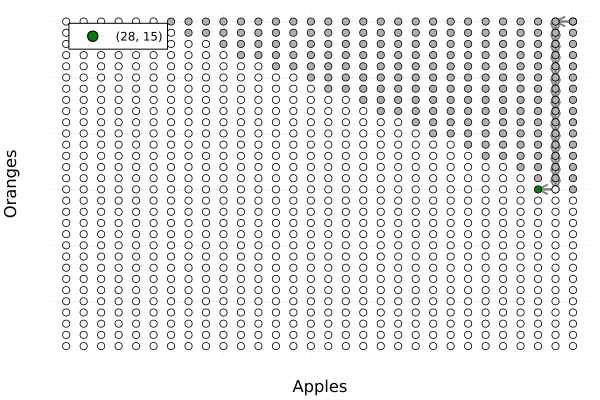

In [14]:
# setup -
# draw the path -
p = plot();
initial_site = (1,30)
hit_absorbing_state = false
s = world.states[initial_site];
visited_sites = Set{Tuple{Int,Int}}();
push!(visited_sites, initial_site);

while (hit_absorbing_state == false)
    current_position = world.coordinates[s]
    a = my_π[s];
    Δ = world.moves[a];
    new_position =  current_position .+ Δ
    scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:blue)
    plot!([current_position[1], new_position[1]],[current_position[2],new_position[2]], label="", arrow=true, lw=2, c=:gray)
    
    if (in(new_position, absorbing_state_set) == true || in(new_position, visited_sites) == true)
        hit_absorbing_state = true;
    else
        s = world.states[new_position];
        push!(visited_sites, new_position);
    end
end

# draw the grid -
for s ∈ 𝒮
    current_position = world.coordinates[s]
    a = my_π[s];
    Δ = world.moves[a];
    new_position =  current_position .+ Δ
    
    if (haskey(rewards, current_position) == true && rewards[current_position] == my_objective_value)
        scatter!([current_position[1]],[current_position[2]], label="$(current_position)", showaxis=:false, c=:green, ms=4)
    elseif (in(current_position, soft_wall_set) == true)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:gray69, ms=4)
    else
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:white)
    end
end
xlabel!("Apples",fontsize=18)
ylabel!("Oranges",fontsize=18)
current()